## Importing modules

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

# Set random seed for reproducibility
np.random.seed(0)

In [2]:
# declaring global font size for plots:
plt.figure()
plt.rcParams.update({'font.size':20})

<Figure size 640x480 with 0 Axes>

## Loading the dataset

In [3]:
# Load the data
df = pd.read_csv('../datasets/complete_data/df.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 37 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   start MTU (UTC)                                                                8760 non-null   object 
 1   Day-ahead Price [EUR/MWh] BZN|NO1                                              8760 non-null   float64
 2   Day-ahead Price [EUR/MWh] BZN|NO3                                              8760 non-null   float64
 3   Day-ahead Price [EUR/MWh] BZN|NO5                                              8760 non-null   float64
 4   Day-ahead Price [EUR/MWh] BZN|SE3                                              8760 non-null   float64
 5   Actual Total Load [MW] - BZN|NO5                                               8760 non-null   float64
 6   Hydro Run-of-river and p

The datatype of the datetime column "start MTU (UTC)" is object, so we need to convert it into a datetime object. We then need to set the "start MTU (UTC)" column as the index, which is required for time series analysis.

In [4]:
# Convert the date column to datetime
df['start MTU (UTC)'] = pd.to_datetime(df['start MTU (UTC)'])

# Set the date column as the index
df.set_index('start MTU (UTC)', inplace=True)


## Splitting the data

In [5]:
# Split the data into training, validation, and test sets
# shuffle is set to false so that the order of the data is maintained
# and the order of the splitting is choosen to maintain the order of the
# the time so train contains the oldest data and test contains the newest data
train, test_valid = train_test_split(df, test_size=0.2, shuffle=False)
valid, test = train_test_split(test_valid, test_size=0.5, shuffle=False)

# Print the shapes of the train, valid, and test sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


Train set shape: (7008, 36)
Validation set shape: (876, 36)
Test set shape: (876, 36)


## Creating a lagged dataset with 24 lag features for each input feature
We want to perform multi-step forecasting where we predict the price at each of the 24 next periods. This can either be done done by direct forecasting or recursive forecasting. In direct forecasting we train the model on predicting all 24 periods into the future. In recursive forecasting we only train the model with a one step ahead forecast, and use it repeatedly to acheive the desired numbers of predicted periods.

When predicting time series, it is important to consider the temporal relationship between observations. Since the observations over time are not independent of each other, we cannot simply use all of the data to train our model as we would in a typical machine learning problem. Instead, we typically create a "lagged" dataset that contains the predictors and the target variable for each time step. This lagged dataset is used to train our model.

To create a lagged dataset, we shift the target variable forward by one or more time steps, using the resulting series as the target variable for that time step. We also include the values of the predictors at the previous time steps as features. This way, the model can learn to use past predictor values to predict future target variable values.

For instance, for hourly data and a prediction horizon of 24 hours, we would create a lagged dataset where each row contains the predictors and the target variable for a specific hour. The target variable for each row would be the value 24 hours in the future, and the predictors for each row would be the values of the predictors for the previous 24 hours. This lagged dataset would then be used to train our model to make predictions for the next 24 hours.

By shifting the target feature forward by 24 periods, we create a dataset where each observation includes the past observations up to the previous period and the target variable value for the next period.

In [6]:
# Function to create lagged dataset wit 24 lag features for each input feature
def create_lagged_dataset(df):
    # creating a copy of the dataframe
    lagged_df = df.copy()
    
    # Adding lagged features for target variable
    lagged_df['Day-ahead Price [EUR/MWh] BZN|NO1'] = lagged_df['Day-ahead Price [EUR/MWh] BZN|NO1'].shift(-1)
    
    # Dropping the last row containing NaN values
    lagged_df.dropna(inplace=True)
    
    # Creating a dataframe with lagged features with 24 steps for each of the original features
    lagged_df = pd.concat([lagged_df.shift(i) for i in range(24)], axis=1)
    
    # Removing the NaN rows that have been created in the beginning of the dataset
    lagged_df.dropna(inplace=True)
    
    return lagged_df

In [7]:
# creating lagged dataset for train and test dataset
lagged_train = create_lagged_dataset(train)
lagged_valid = create_lagged_dataset(valid)
lagged_test = create_lagged_dataset(test)


In [8]:
# separating the target feature and the input features
train_y = lagged_train['Day-ahead Price [EUR/MWh] BZN|NO1']
train_x = lagged_train.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

valid_y = lagged_valid['Day-ahead Price [EUR/MWh] BZN|NO1']
valid_x = lagged_valid.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

test_y = lagged_test['Day-ahead Price [EUR/MWh] BZN|NO1']
test_x = lagged_test.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

#print the shapes of the datasets
print("Train Data Shape: ", train_x.shape, train_y.shape)
print("Validation Data Shape: ", valid_x.shape, valid_y.shape)
print("Test Data Shape: ", test_x.shape, test_y.shape)

Train Data Shape:  (6984, 840) (6984, 24)
Validation Data Shape:  (852, 840) (852, 24)
Test Data Shape:  (852, 840) (852, 24)


## Training the baseline model

In [9]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# start timer
start_time = time.time()

# Fit the model on the training data
rf.fit(train_x, train_y)

# stop timer
end_time = time.time()

# Make predictions on the train data
train_pred_y = rf.predict(train_x)

# Make predictions on the test data
test_pred_y = rf.predict(test_x)

# print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time), "\n")

# Calculate the mean absolute error (MAE) between the predicted and actual values for train data
train_mae = mean_absolute_error(train_y, train_pred_y)
print("Train Mean absolute error:            ", train_mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values for train data
train_mape = mean_absolute_percentage_error(train_y, train_pred_y)
print("Train Mean absolute percentage error: ", train_mape)

# Calculating the mean squared error (MSE) between the predicted and actual values for train data
train_mse = mean_squared_error(train_y, train_pred_y)
print("Train Mean squared error:             ", train_mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values for train data
train_rmse = math.sqrt(train_mse)
print("Train Rood mean squared error:        ", train_rmse, "\n")

# Calculate the mean absolute error (MAE) between the predicted and actual values for test data
test_mae = mean_absolute_error(test_y, test_pred_y)
print("Test Mean absolute error:            ", test_mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values for test data
test_mape = mean_absolute_percentage_error(test_y, test_pred_y)
print("Test Mean absolute percentage error: ", test_mape)

# Calculating the mean squared error (MSE) between the predicted and actual values for test data
test_mse = mean_squared_error(test_y, test_pred_y)
print("Test Mean squared error:             ", test_mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values for test data
test_rmse = math.sqrt(test_mse)
print("Test Rood mean squared error:        ", test_rmse)


Runtime: 395.91 seconds 

Train Mean absolute error:             2.441857339088275
Train Mean absolute percentage error:  0.014090314573828783
Train Mean squared error:              18.154510559896437
Train Rood mean squared error:         4.260811021378023 

Test Mean absolute error:             20.970617397406194
Test Mean absolute percentage error:  0.08930201861731757
Test Mean squared error:              926.6677191806621
Test Rood mean squared error:         30.44121743920013


## Plotting mean of predicted vs mean of actual values for the base rf model:

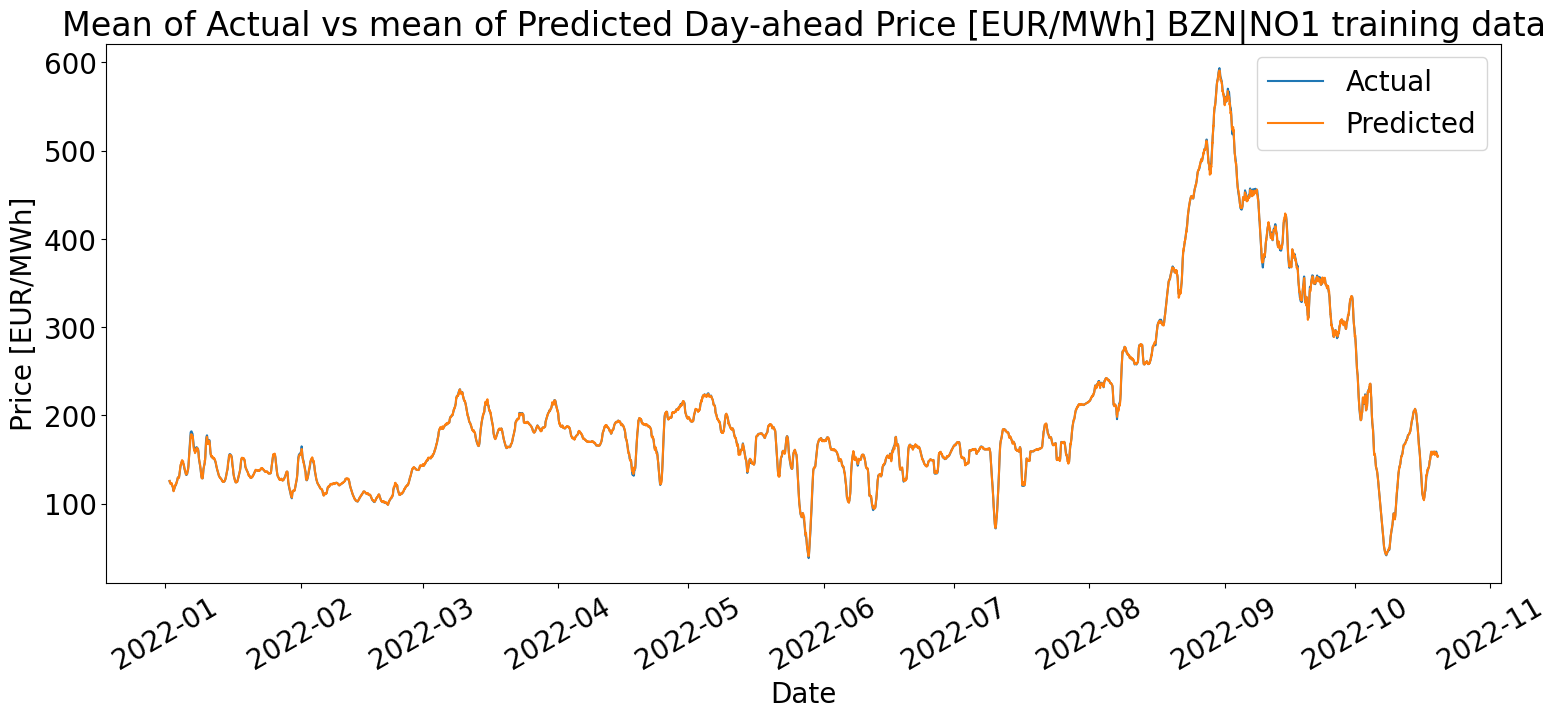

In [10]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(train_y.index, np.mean(train_y, axis=1), label='Actual')
plt.plot(train_y.index, np.mean(rf.predict(train_x), axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 training data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()


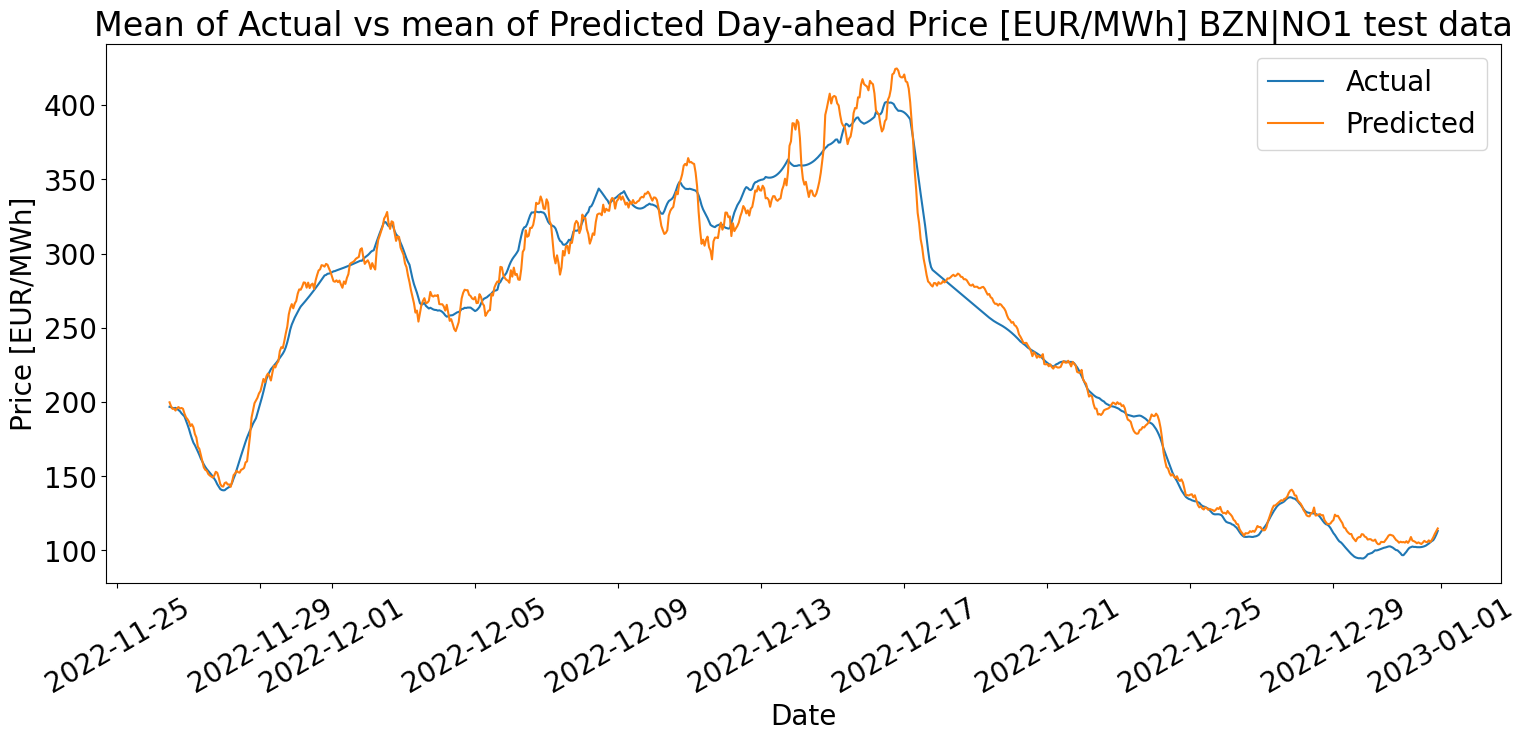

In [12]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(test_y.index, np.mean(test_y, axis=1), label='Actual')
plt.plot(test_y.index, np.mean(rf.predict(test_x), axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 test data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()


When considering MAPE, it is common to use a benchmark below 10% as a reference point. However, it is essential to note that this standard can differ based on the industry and particular application. For instance, in the finance sector, a MAPE lower than 2% might be regarded as favorable.
Determining a good value for RMSE relies on the data's scale under analysis. It is customary to compare the RMSE with the range of the target variable. Generally, an RMSE that accounts for less than 10% of the target variable's range can be deemed satisfactory.

## hyper parameter tuning

To handle the time series nature of the data, rolling origin cross-validation is used, which involves training the model on a rolling window of historical data and testing it on the next observation. The primary benefit of using the rolling origin cross-validation method is that it maintains the temporal order of the data, which is essential for accurate time series forecasting. This approach ensures that the model is evaluated on data that is more similar to the future data it will be predicting.

A random search is performed on a dictionary of hyperparameters to search for the best combination of hyperparameters for the random forest regressor model. The hyperparameters tuned in this process include the number of trees in the forest (n_estimators), the maximum depth of each tree (max_depth), the minimum number of samples required to split an internal node (min_samples_split), the minimum number of samples required to be at a leaf node (min_samples_leaf), and the maximum number of features to consider when looking for the best split (max_features).

In [ ]:
# Create a random forest regressor object
rf = RandomForestRegressor(random_state=0)

# Define a dictionary of hyperparameters to search
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

n_folds = 5

# Initialize lists to store the performance metricsD
rmse_scores = []
mae_scores = []
mape_scores = []
mse_scores = []

# start timer
start_time = time.time()

# Perform rolling origin cross-validation
for i in range(n_folds, len(valid_y)):
    # Split the data into training and validation sets
    train_y = valid_y.iloc[i-n_folds:i]
    train_x = valid_x.iloc[i-n_folds:i]
    val_y = valid_y.iloc[i:i+1]
    val_x = valid_x.iloc[i:i+1]

    # Perform a random search on the training data
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=n_folds, n_jobs=-1, random_state=0, scoring='neg_mean_squared_error')
    random_search.fit(train_x, train_y)

    # Extract the best model from the random search
    best_rf_model = random_search.best_estimator_

    # Make predictions on the validation data using the best model
    val_predictions = best_rf_model.predict(val_x)

    # Calculate the performance metrics for the current fold
    rmse_scores.append(math.sqrt(mean_squared_error(val_y, val_predictions)))
    mae_scores.append(mean_absolute_error(val_y, val_predictions))
    mape_scores.append(mean_absolute_percentage_error(val_y, val_predictions))
    mse_scores.append(mean_squared_error(val_y, val_predictions))



# Print the runtime
print("Runtime: {:.2f} seconds".format(end_time - start_time))

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Print the average performance metrics over all folds
print("Average Mean Absolute Error (MAE):", round(np.mean(mae_scores), 2))
print("Average Mean Absolute Percentage Error (MAPE):", round(np.mean(mape_scores), 2), "%")
print("Average Mean Squared Error (MSE):", round(np.mean(mse_scores), 2))
print("Average Root Mean Squared Error (RMSE):", round(np.mean(rmse_scores), 2))


## Plotting mean of predicted vs mean of actual values for the best rf model with validation data:

In [ ]:
# Define the optimal hyperparameters found through random search
optimal_params = random_search.best_params_

# Create a random forest regressor object with the optimal hyperparameters
rf = RandomForestRegressor(**optimal_params, random_state=0)

# Train the model on the validation data
rf.fit(valid_x, valid_y)

# Make predictions on the validation data using the trained model
valid_pred_y = rf.predict(valid_x)
test_pred_y = rf.predict(test_x)

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 10))

# Plot the mean of the actual and predicted values
plt.plot(valid_y.index, np.mean(valid_y, axis=1), label='Actual')
plt.plot(valid_y.index, np.mean(valid_pred_y, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 validation data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 10))

# Plot the mean of the actual and predicted values
plt.plot(test_y.index, np.mean(test_y, axis=1), label='Actual')
plt.plot(test_y.index, np.mean(test_pred_y, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 test data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In order to assess the performance of the model with the optimal hyperparameters on the test data, we must first train the model on the combined training and validation data using the tuned hyperparameters obtained from the cross-validation random search. After training the model, we can use it to make predictions on the test data and measure its performance using the same metrics (MAE, MAPE, MSE, and RMSE) that were used to evaluate its performance on the validation data.

In [ ]:
# Combine the training and validation data
train_x = pd.concat([train_x, valid_x])
train_y = pd.concat([train_y, valid_y])

# Define the optimal hyperparameters found through random search
optimal_params = random_search.best_params_

# Create a random forest regressor object with the optimal hyperparameters
rf = RandomForestRegressor(**optimal_params, random_state=0)

# Train the model on the combined training and validation data
rf.fit(train_x, train_y)

# Make predictions on the training and test data using the trained model
train_pred_y = rf.predict(train_x)
test_pred_y = rf.predict(test_x)

# Evaluate the performance of the model on the training and test data using the same metrics used for validation data
train_rmse = math.sqrt(mean_squared_error(train_y, train_pred_y))
train_mae = mean_absolute_error(train_y, train_pred_y)
train_mape = mean_absolute_percentage_error(train_y, train_pred_y)
train_mse = mean_squared_error(train_y, train_pred_y)

test_rmse = math.sqrt(mean_squared_error(test_y, test_pred_y))
test_mae = mean_absolute_error(test_y, test_pred_y)
test_mape = mean_absolute_percentage_error(test_y, test_pred_y)
test_mse = mean_squared_error(test_y, test_pred_y)

# Print the performance metrics on the training and test data
print("Performance metrics on the training data:")
print("Root Mean Squared Error on Training Data:", round(train_rmse, 2))
print("Mean Absolute Error on Training Data:", round(train_mae, 2))
print("Mean Absolute Percentage Error on Training Data:", round(train_mape, 2))
print("Mean Squared Error on Training Data:", round(train_mse, 2))

print("\nPerformance metrics on the test data:")
print("Root Mean Squared Error on Test Data:", round(test_rmse, 2))
print("Mean Absolute Error on Test Data:", round(test_mae, 2))
print("Mean Absolute Percentage Error on Test Data:", round(test_mape, 2))
print("Mean Squared Error on Test Data:", round(test_mse, 2))


## Plotting mean of predicted vs mean of actual values for the best rf model with train + validation data:

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 10))

# Plot the mean of the actual and predicted values
plt.plot(train_y.index, np.mean(train_y, axis=1), label='Actual')
plt.plot(train_y.index, np.mean(train_pred_y, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 train + validation data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 10))

# Plot the mean of the actual and predicted values
plt.plot(test_y.index, np.mean(test_y, axis=1), label='Actual')
plt.plot(test_y.index, np.mean(test_pred_y, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 test data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

##  feature reduction with feature importance

In [ ]:
# Load the data
df = pd.read_csv('../datasets/complete_data/df.csv')

In [ ]:
# Convert the date column to datetime
df['start MTU (UTC)'] = pd.to_datetime(df['start MTU (UTC)'])

# Set the date column as the index
df.set_index('start MTU (UTC)', inplace=True)

In [ ]:
# Split the data into training, validation, and test sets
# shuffle is set to false so that the order of the data is maintained
# and the order of the splitting is choosen to maintain the order of the
# the time so train contains the oldest data and test contains the newest data
train, test_valid = train_test_split(df, test_size=0.2, shuffle=False)
valid, test = train_test_split(test_valid, test_size=0.5, shuffle=False)

# Print the shapes of the train, valid, and test sets
print("Train set shape:", train.shape)
print("Validation set shape:", valid.shape)
print("Test set shape:", test.shape)


In [ ]:
# Separate the features and target variable
X_train = train.drop('Day-ahead Price [EUR/MWh] BZN|NO1', axis=1)
y_train = train['Day-ahead Price [EUR/MWh] BZN|NO1']

# Train the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Get the feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Print the feature importances in descending order
print(sorted_importances)

In [ ]:
# Get the feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort the feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

# Print the feature importances in descending order
print(sorted_importances)

# Get the names of the top 10 features, including the target variable
top_10_features = sorted_importances[:10].index.tolist()
top_10_features.append('Day-ahead Price [EUR/MWh] BZN|NO1')

# Filter the top 10 features in the training, validation, and test sets
train = train[top_10_features]
valid = valid[top_10_features]
test = test[top_10_features]

# Print the remaining feature names
print('Remaining features:', list(train.columns))


In [ ]:
# creating lagged dataset for train and test dataset
lagged_train = create_lagged_dataset(train)
lagged_valid = create_lagged_dataset(valid)
lagged_test = create_lagged_dataset(test)

In [ ]:
# separating the target feature and the input features
train_y = lagged_train['Day-ahead Price [EUR/MWh] BZN|NO1']
train_x = lagged_train.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

valid_y = lagged_valid['Day-ahead Price [EUR/MWh] BZN|NO1']
valid_x = lagged_valid.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

test_y = lagged_test['Day-ahead Price [EUR/MWh] BZN|NO1']
test_x = lagged_test.drop(['Day-ahead Price [EUR/MWh] BZN|NO1'], axis=1)

#print the shapes of the datasets
print("Train Data Shape: ", train_x.shape, train_y.shape)
print("Validation Data Shape: ", valid_x.shape, valid_y.shape)
print("Test Data Shape: ", test_x.shape, test_y.shape)

## training the baseline model with feature reduction

In [ ]:
# Create a random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=0, max_features=0.5, min_samples_leaf = 20)

# start timer
start_time = time.time()

# Fit the model on the training data
rf.fit(train_x, train_y)

# stop timer
end_time = time.time()

# Make predictions on the train data
train_pred_y = rf.predict(train_x)

# Make predictions on the test data
test_pred_y = rf.predict(test_x)

# print the run time
print("Runtime: {:.2f} seconds".format(end_time - start_time), "\n")

# Calculate the mean absolute error (MAE) between the predicted and actual values for train data
train_mae = mean_absolute_error(train_y, train_pred_y)
print("Train Mean absolute error:            ", train_mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values for train data
train_mape = mean_absolute_percentage_error(train_y, train_pred_y)
print("Train Mean absolute percentage error: ", train_mape)

# Calculating the mean squared error (MSE) between the predicted and actual values for train data
train_mse = mean_squared_error(train_y, train_pred_y)
print("Train Mean squared error:             ", train_mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values for train data
train_rmse = math.sqrt(train_mse)
print("Train Rood mean squared error:        ", train_rmse, "\n")

# Calculate the mean absolute error (MAE) between the predicted and actual values for test data
test_mae = mean_absolute_error(test_y, test_pred_y)
print("Test Mean absolute error:            ", test_mae)

# Calculate the mean absolute percentage error (MAE) between the predicted and actual values for test data
test_mape = mean_absolute_percentage_error(test_y, test_pred_y)
print("Test Mean absolute percentage error: ", test_mape)

# Calculating the mean squared error (MSE) between the predicted and actual values for test data
test_mse = mean_squared_error(test_y, test_pred_y)
print("Test Mean squared error:             ", test_mse)

# Calculating the root mean squared error (RMSE) between the predicted and actual values for test data
test_rmse = math.sqrt(test_mse)
print("Test Rood mean squared error:        ", test_rmse)


In [ ]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(train_y.index, np.mean(train_y, axis=1), label='Actual')
plt.plot(train_y.index, np.mean(rf.predict(train_x), axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 feature reduced training data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(18, 7))

# Plot the mean of the actual and predicted values
plt.plot(test_y.index, np.mean(test_y, axis=1), label='Actual')
plt.plot(test_y.index, np.mean(pred_y, axis=1), label='Predicted')

# Set the title and axis labels
plt.title('Mean of Actual vs mean of Predicted Day-ahead Price [EUR/MWh] BZN|NO1 feature reduced test data')
plt.xlabel('Date')
plt.ylabel('Price [EUR/MWh]')

# Rotate the x-axis labels
plt.xticks(rotation=30)

# Add a legend
plt.legend()

# Show the plot
plt.show()